# REGRESSION: Bitcoin Price Forecast

***


## INTRODUCTION

This project used data from <b style="color:#4361ee">Kraken API</b> and initially applid one machine learning model, <b style="color:#4361ee">Support Vector Machine</b>, to forcast the future price of <b style="color:#4361ee">Bitcoin.</b>

In [161]:
import numpy as np
import pandas as pd
import json
import datetime
import time
import requests

In [162]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["font.size"]=14
matplotlib.rcParams["figure.figsize"]= (18,8)
matplotlib.rcParams["figure.facecolor"]="#00000000"

import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px

## DATA COLLECTION

Kraken gives historical cryptocurrency data. However, the current historical data available is March 31, 2022.
Therefore, additional data need to be pulled from the API market data endpoint.

### 1. Kraken Historical OHLCVT 

* https://support.kraken.com/hc/en-us/articles/360047124832-Downloadable-historical-OHLCVT-Open-High-Low-Close-Volume-Trades-data

* The data given is in one minute timeframe, so we will use the 1440 (daily timeframe)
* The date is in Unix timestamp, so need to be converted to regular date time 

In [163]:
# The columns from the csv file
xbt_cols = ["date","open", "high", "low", "close", "volume", "trades"]

In [164]:
xbt_raw = pd.read_csv("data/XBTUSD_1440.csv", names=xbt_cols)

In [165]:
# Convert Unix timestamp
xbt_raw["date"] = pd.to_datetime(xbt_raw["date"],unit='s')

In [166]:
xbt_raw.to_csv("data/xbt_raw.csv")

### 2. Kraken API Market data OHLC endpoint
* Using OHLC endpoint for 2022 data
* https://docs.kraken.com/rest/#operation/getTickerInformation
* Unix timestamp converter https://www.epochconverter.com/

In [167]:
# The columns from OHLC API (different from historical data)

kraken_ohlc_cols = ["date","open", "high", "low", "close", "vwap","volume", "trades"]

* Without specifying "since" parameter, the response will give the current day data and only 720 data available

In [168]:
resp = requests.get('https://api.kraken.com/0/public/OHLC?pair=XBTUSD&interval=1440&since=unix_now').json()

In [169]:
xbt_apr22_df = pd.DataFrame(resp["result"]['XXBTZUSD'])

In [170]:
xbt_apr22_df.columns = kraken_ohlc_cols

In [171]:
xbt_apr22_df["date"] = pd.to_datetime(xbt_apr22_df["date"],unit='s')
xbt_apr22_df.head(3)

,date,open,high,low,close,vwap,volume,trades
0,2020-06-05,9792.1,9855.0,9537.9,9617.7,9719.6,5121.00668816,15855
1,2020-06-06,9617.6,9731.2,9527.4,9672.0,9635.6,2681.15313308,10113
2,2020-06-07,9668.7,9812.4,9386.6,9757.7,9599.6,4869.61667609,15720


In [172]:
xbt_apr22_df.tail(3)

,date,open,high,low,close,vwap,volume,trades
717,2022-05-23,30264.4,30630.7,28829.5,29070.0,29874.3,3028.92781142,22623
718,2022-05-24,29070.0,29819.7,28635.3,29631.8,29243.5,2806.17199551,18978
719,2022-05-25,29628.0,30188.9,29522.6,30084.1,29901.9,483.75817429,3147


### Appending data from OHLC API to dataframe from historical data

<b>Drop vwap column since there's no vwap column in the historical data</b>

In [173]:
# Drop vwap column since there's no vwap column in the historical data

xbt_apr22_df.drop("vwap", axis=1, inplace=True)
xbt_apr22_df.head(3)

,date,open,high,low,close,volume,trades
0,2020-06-05,9792.1,9855.0,9537.9,9617.7,5121.00668816,15855
1,2020-06-06,9617.6,9731.2,9527.4,9672.0,2681.15313308,10113
2,2020-06-07,9668.7,9812.4,9386.6,9757.7,4869.61667609,15720


<b> Select the data after March 31,2022 </b>

In [353]:
xbt_apr22 = xbt_apr22_df[xbt_apr22_df["date"] > "2022-03-31"]

<b> Combine the two dataframes</b>

In [175]:
btc_df_raw = pd.concat([xbt_raw, xbt_apr22],ignore_index=True)

In [176]:
btc_df_raw.head(3)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.0,122.0,122.0,122.0,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1
2,2013-10-08,123.91,124.19,123.9,124.18,3.9916,4


In [177]:
btc_df_raw.tail(3)

,date,open,high,low,close,volume,trades
3139,2022-05-23,30264.4,30630.7,28829.5,29070.0,3028.92781142,22623
3140,2022-05-24,29070.0,29819.7,28635.3,29631.8,2806.17199551,18978
3141,2022-05-25,29628.0,30188.9,29522.6,30084.1,483.75817429,3147


In [178]:
btc_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3142 non-null   datetime64[ns]
 1   open    3142 non-null   object        
 2   high    3142 non-null   object        
 3   low     3142 non-null   object        
 4   close   3142 non-null   object        
 5   volume  3142 non-null   object        
 6   trades  3142 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 172.0+ KB


In [179]:
btc_df_raw = btc_df_raw.astype({"open":"float64", 
                               "high":"float64", 
                                "low":"float64", 
                               "close":"float64", 
                             "volume":"float64"})

In [180]:
btc_df_raw.to_csv("data/btc_df_raw.csv") # save data for later use


## DATA PREPROCESSING


### Create more features 

In [181]:
btc_df = pd.read_csv("data/btc_df_raw.csv", index_col=0)

In [182]:
btc_df.head(2)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.00,122.00,122.00,122.00,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1


In [183]:
btc_df.tail(2)

,date,open,high,low,close,volume,trades
3140,2022-05-24,29070.0,29819.7,28635.3,29631.8,2806.171996,18978
3141,2022-05-25,29628.0,30188.9,29522.6,30084.1,483.758174,3147


In [184]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3142 non-null   object 
 1   open    3142 non-null   float64
 2   high    3142 non-null   float64
 3   low     3142 non-null   float64
 4   close   3142 non-null   float64
 5   volume  3142 non-null   float64
 6   trades  3142 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 196.4+ KB


#### Split date column to year, month, day

In [185]:
def date_split(df):
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    return(df)

In [186]:
btc_df = date_split(btc_df)

In [187]:
btc_df = btc_df[["date","year", "month", "day", "open", "high", "low", "close", "volume", "trades"]]

In [188]:
btc_df.head(3)

,date,year,month,day,open,high,low,close,volume,trades
0,2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
1,2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2,2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


In [189]:
btc_df = btc_df.set_index("date")

In [190]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades
date,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


#### Adding Yesterday prices, volume, trades

In [191]:
def yesterday_data(df):
    df["open_yesterday"] = df["open"].shift(1)
    df["high_yesterday"] = df["high"].shift(1)
    df["low_yesterday"] = df["low"].shift(1)
    df["close_yesterday"] = df["close"].shift(1)
    df["volume_yesterday"] = df["volume"].shift(1)
    df["trades_yesterday"] = df["trades"].shift(1)
    return(df)

In [192]:
btc_df = yesterday_data(btc_df)

#### Adding % change of yesterday and the day before yesterday

price_1D_change = (today_price - yesterday_price)/yesterday_price

In [193]:
def change_1D(df):
    df["open_1D_change"] = btc_df["open"].pct_change().shift(1)
    df["high_1D_change"] = btc_df["high"].pct_change().shift(1)
    df["low_1D_change"]  = df["low"].pct_change().shift(1)
    df["close_1D_change"] = df["close"].pct_change().shift(1)
    df["volume_1D_change"] = df["volume"].pct_change().shift(1)
    df["trades_1D_change"] = df["trades"].pct_change().shift(1)
    return(df)
    

In [194]:
btc_df = change_1D(btc_df)

#### Average 7 days

- rolling will include the current row to calculate
- so if we are at row#8 (index=7), we can calculate mean of the first 7 rows 
- then shiff the value to row#8

In [195]:
def moving_ave_7(df):
    df["open_average_7D"] = df["open"].rolling(7).mean().shift(1)
    df["high_average_7D"] = df["high"].rolling(7).mean().shift(1)
    df["low_average_7D"] = df["low"].rolling(7).mean().shift(1)
    df["close_average_7D"] = df["close"].rolling(7).mean().shift(1)
    df["volume_average_7D"] = df["volume"].rolling(7).mean().shift(1)
    df["trades_average_7D"] = df["trades"].rolling(7).mean().shift(1)
    
    return(df)

In [196]:
btc_df = moving_ave_7(btc_df)

#### % change 7 days

In [197]:
def change_pct_7D(df):
    df["open_%change_7D"] = df["open_1D_change"].rolling(7).mean().shift(1)
    df["high_%change_7D"] = df["high_1D_change"].rolling(7).mean().shift(1)
    df["low_%change_7D"] = df["low_1D_change"].rolling(7).mean().shift(1)
    df["close_%change_7D"] = df["close_1D_change"].rolling(7).mean().shift(1)
    df["volume_%change_7D"] = df["volume_1D_change"].rolling(7).mean().shift(1)
    df["trades_%change_7D"] = df["trades_1D_change"].rolling(7).mean().shift(1)
    
    return(df)

In [198]:
btc_df = change_pct_7D(btc_df)

#### Simple Moving Average 9, 20, 50
- Will only use ["close"] here

In [199]:
def moving_avgs_pop(df):
    df["moving_average_9"] = df["close"].rolling(9).mean().shift(1)
    df["moving_average_20"] = df["close"].rolling(20).mean().shift(1)
    df["moving_average_50"] = df["close"].rolling(50).mean().shift(1)
    
    return(df)

In [200]:
btc_df = moving_avgs_pop(btc_df)

<b> Set the display to see all columns </b>

In [201]:
pd.set_option("display.max_columns", len(btc_df.columns))

In [202]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1,122.00,122.00,122.00,122.00,0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4,123.61,123.61,123.61,123.61,0.1,1.0,0.013197,0.013197,0.013197,0.013197,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-05-23,2022,5,23,30264.4,30630.7,28829.5,29070.0,3028.927811,22623,29394.4,30500.0,29225.7,30268.0,1862.492124,15723.0,0.007983,0.030186,0.010316,0.029401,0.808139,0.178459,29860.900000,30574.400000,28936.342857,29716.914286,3003.501844,22435.714286,0.000583,-0.002917,0.001769,-0.002222,0.047226,-0.087159,29929.277778,31852.845,37287.416
2022-05-24,2022,5,24,29070.0,29819.7,28635.3,29631.8,2806.171996,18978,30264.4,30630.7,28829.5,29070.0,3028.927811,22623.0,0.029597,0.004285,-0.013557,-0.039580,0.626277,0.438848,29713.742857,30479.571429,28903.414286,29608.900000,2907.180888,21537.142857,-0.002278,-0.003920,-0.001014,-0.003958,0.223454,-0.032349,29820.588889,31419.950,36940.348
2022-05-25,2022,5,25,29628.0,30188.9,29522.6,30084.1,483.758174,3147,29070.0,29819.7,28635.3,29631.8,2806.171996,18978.0,-0.039466,-0.026477,-0.006736,0.019326,-0.073543,-0.161119,29605.728571,30347.814286,28793.742857,29497.971429,2906.511067,20862.000000,-0.003958,-0.002873,-0.001046,-0.002899,0.120926,0.001771,29635.577778,30917.400,36600.642


#### Drop NaN

In [204]:
len(btc_df)

3142

In [205]:
btc_df = btc_df.dropna()

In [206]:
len(btc_df)

3092

In [207]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [208]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-05-23,2022,5,23,30264.4,30630.7,28829.5,29070.0,3028.927811,22623,29394.4,30500.0,29225.7,30268.0,1862.492124,15723.0,0.007983,0.030186,0.010316,0.029401,0.808139,0.178459,29860.900000,30574.400000,28936.342857,29716.914286,3003.501844,22435.714286,0.000583,-0.002917,0.001769,-0.002222,0.047226,-0.087159,29929.277778,31852.845,37287.416
2022-05-24,2022,5,24,29070.0,29819.7,28635.3,29631.8,2806.171996,18978,30264.4,30630.7,28829.5,29070.0,3028.927811,22623.0,0.029597,0.004285,-0.013557,-0.039580,0.626277,0.438848,29713.742857,30479.571429,28903.414286,29608.900000,2907.180888,21537.142857,-0.002278,-0.003920,-0.001014,-0.003958,0.223454,-0.032349,29820.588889,31419.950,36940.348
2022-05-25,2022,5,25,29628.0,30188.9,29522.6,30084.1,483.758174,3147,29070.0,29819.7,28635.3,29631.8,2806.171996,18978.0,-0.039466,-0.026477,-0.006736,0.019326,-0.073543,-0.161119,29605.728571,30347.814286,28793.742857,29497.971429,2906.511067,20862.000000,-0.003958,-0.002873,-0.001046,-0.002899,0.120926,0.001771,29635.577778,30917.400,36600.642


#### Save dataframe for later use for Machine Learaning model

In [259]:
btc_df.to_csv("data/btc_df.csv")

# VISUALIZATION

In [260]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [261]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-05-23,2022,5,23,30264.4,30630.7,28829.5,29070.0,3028.927811,22623,29394.4,30500.0,29225.7,30268.0,1862.492124,15723.0,0.007983,0.030186,0.010316,0.029401,0.808139,0.178459,29860.900000,30574.400000,28936.342857,29716.914286,3003.501844,22435.714286,0.000583,-0.002917,0.001769,-0.002222,0.047226,-0.087159,29929.277778,31852.845,37287.416
2022-05-24,2022,5,24,29070.0,29819.7,28635.3,29631.8,2806.171996,18978,30264.4,30630.7,28829.5,29070.0,3028.927811,22623.0,0.029597,0.004285,-0.013557,-0.039580,0.626277,0.438848,29713.742857,30479.571429,28903.414286,29608.900000,2907.180888,21537.142857,-0.002278,-0.003920,-0.001014,-0.003958,0.223454,-0.032349,29820.588889,31419.950,36940.348
2022-05-25,2022,5,25,29628.0,30188.9,29522.6,30084.1,483.758174,3147,29070.0,29819.7,28635.3,29631.8,2806.171996,18978.0,-0.039466,-0.026477,-0.006736,0.019326,-0.073543,-0.161119,29605.728571,30347.814286,28793.742857,29497.971429,2906.511067,20862.000000,-0.003958,-0.002873,-0.001046,-0.002899,0.120926,0.001771,29635.577778,30917.400,36600.642


In [262]:
btc_df_viz = btc_df[:-1]  # drop last row because the trading day isn't closed yet

In [263]:
btc_df_viz.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [264]:
btc_df_viz.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-05-22,2022,5,22,29394.4,30500.0,29225.7,30268.0,1862.492124,15723,29161.6,29606.3,28927.3,29403.5,1030.060249,13342.0,-0.037053,-0.036291,0.007916,0.008091,-0.722920,-0.444708,29954.800000,30701.542857,28968.757143,29863.900000,2963.127501,23631.571429,0.007304,-0.000971,0.000219,0.000658,0.099217,-0.047602,29813.122222,32264.440,37598.628
2022-05-23,2022,5,23,30264.4,30630.7,28829.5,29070.0,3028.927811,22623,29394.4,30500.0,29225.7,30268.0,1862.492124,15723.0,0.007983,0.030186,0.010316,0.029401,0.808139,0.178459,29860.900000,30574.400000,28936.342857,29716.914286,3003.501844,22435.714286,0.000583,-0.002917,0.001769,-0.002222,0.047226,-0.087159,29929.277778,31852.845,37287.416
2022-05-24,2022,5,24,29070.0,29819.7,28635.3,29631.8,2806.171996,18978,30264.4,30630.7,28829.5,29070.0,3028.927811,22623.0,0.029597,0.004285,-0.013557,-0.039580,0.626277,0.438848,29713.742857,30479.571429,28903.414286,29608.900000,2907.180888,21537.142857,-0.002278,-0.003920,-0.001014,-0.003958,0.223454,-0.032349,29820.588889,31419.950,36940.348


<b> Close Price Trend </b>

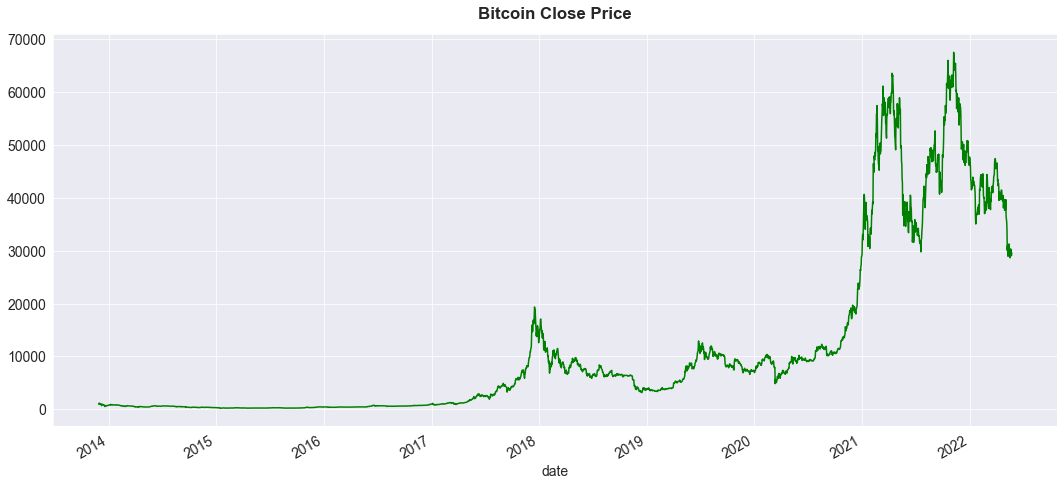

In [236]:
btc_df_viz['close'].plot(color="green") 
plt.title("Bitcoin Close Price", fontweight="bold", y=1.025)#fontname="Times New Roman"
plt.show()

<b> Volume Trend </b>

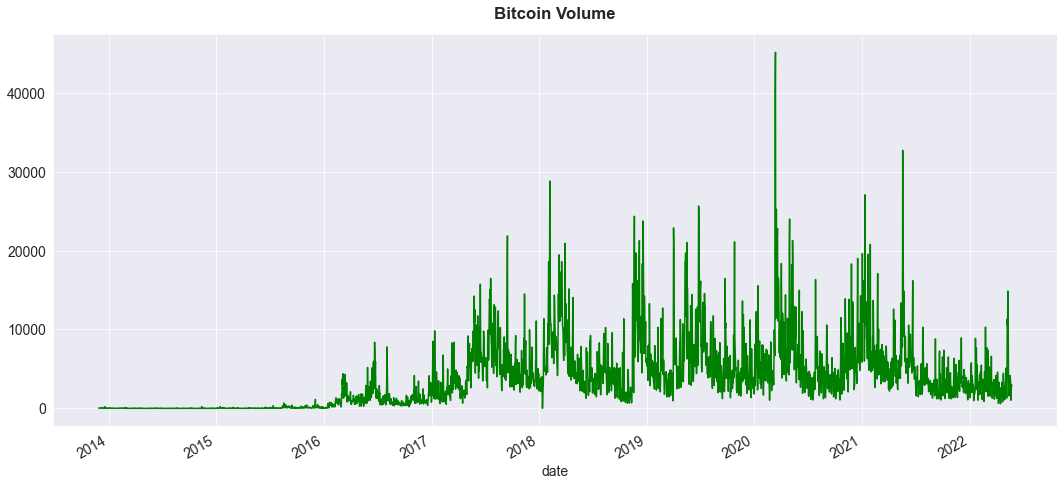

In [237]:
btc_df_viz['volume'].plot(color="green")
plt.title("Bitcoin Volume", fontweight="bold", y=1.025)
plt.show()

<b> Trades Trend </b>

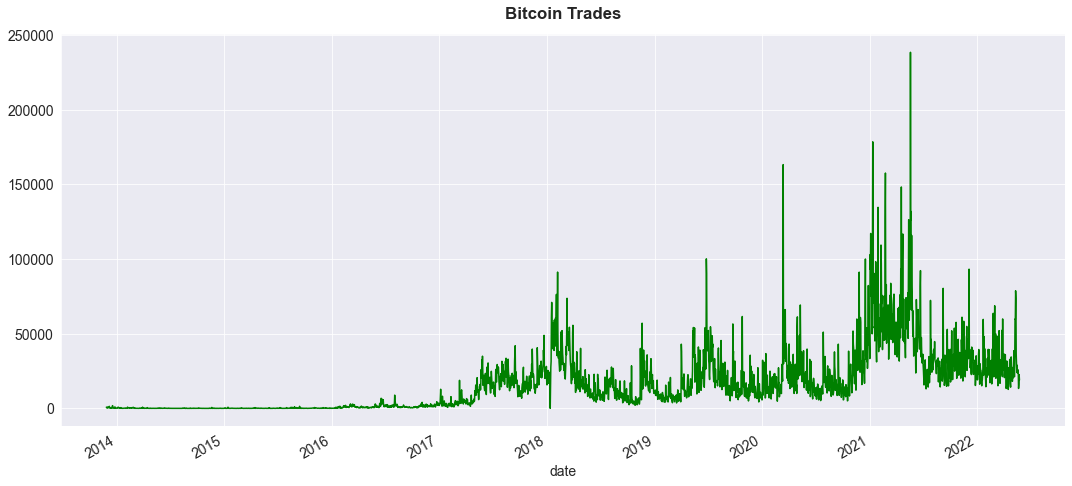

In [238]:
btc_df_viz['trades'].plot(color="green")
plt.title("Bitcoin Trades", fontweight="bold", y=1.025)
plt.show()

<b> Box Plot Close Price </b>

Text(0, 0.5, '')

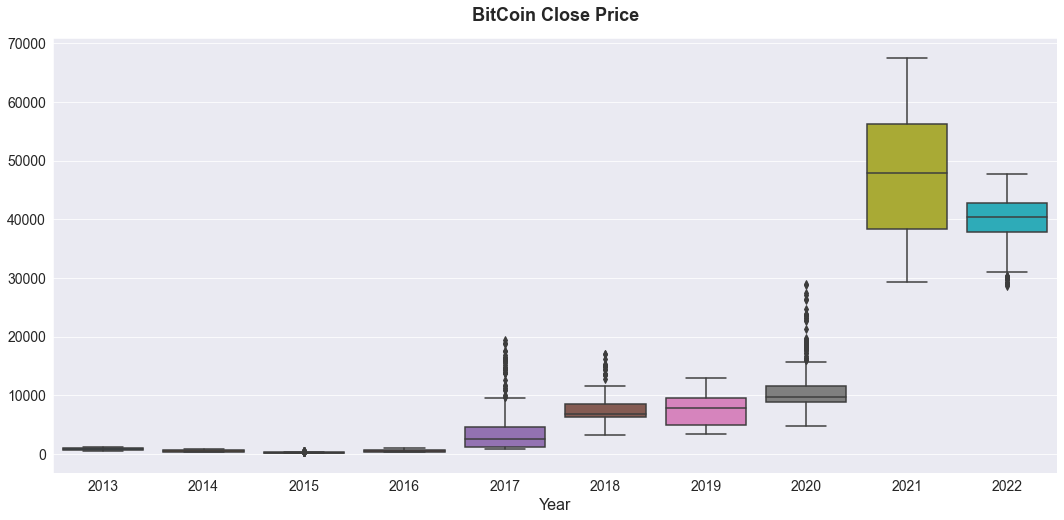

In [239]:
box = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["close"], data=btc_df_viz)

box.set_title("BitCoin Close Price",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box.set_xlabel("Year", fontsize=16)
box.set_ylabel(None, fontsize=16)


<b> Box Plot Volume </b>

Text(0, 0.5, '')

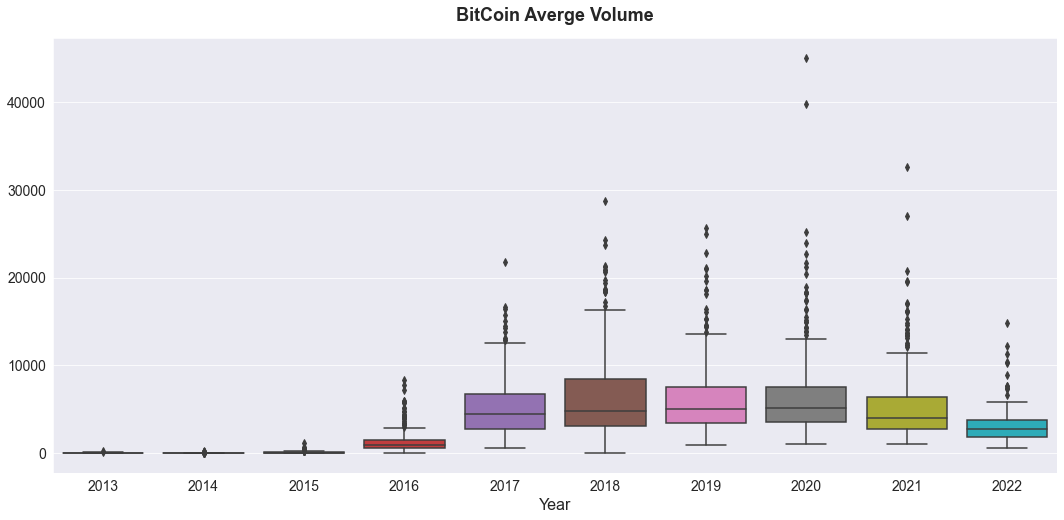

In [240]:
box1 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["volume"], data=btc_df_viz)

box1.set_title("BitCoin Averge Volume",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box1.set_xlabel("Year", fontsize=16)
box1.set_ylabel(None, fontsize=16)


<b> Box Plot Trades </b>

Text(0, 0.5, '')

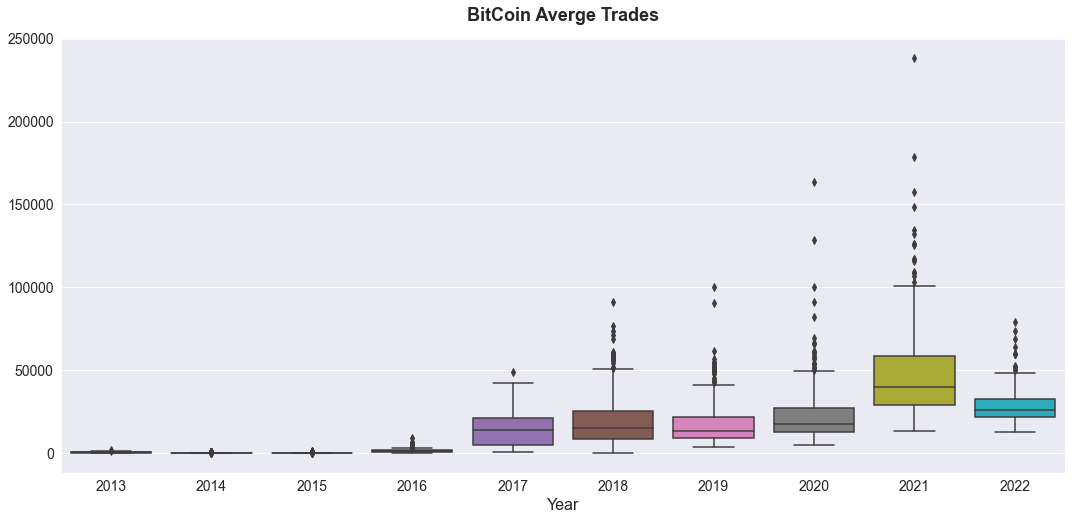

In [241]:
box2 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["trades"], data=btc_df_viz)

box2.set_title("BitCoin Averge Trades",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box2.set_xlabel("Year", fontsize=16)
box2.set_ylabel(None, fontsize=16)

#### 2022 Monthly Close Price 

In [242]:
filt = btc_df_viz["year"]='2022'

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_8179/2934939315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt = btc_df_viz["year"]='2022'


In [244]:
btc_df_viz_2022=btc_df_viz[filt].copy()

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_8179/3793007838.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  btc_df_viz_2022=btc_df_viz[filt].copy()


Text(0, 0.5, '')

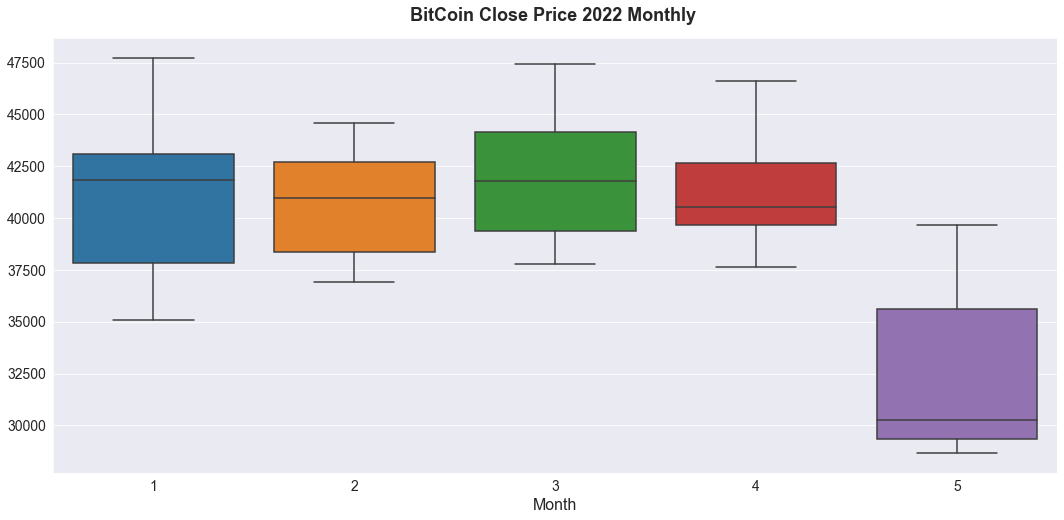

In [245]:
box = sns.boxplot(x=btc_df_viz_2022["month"], y=btc_df_viz_2022["close"], data=btc_df_viz_2022)

box.set_title("BitCoin Close Price 2022 Monthly ",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box.set_xlabel("Month", fontsize=16)
box.set_ylabel(None, fontsize=16)

In [265]:
btc_df_viz = btc_df_viz.astype({"year":"int"})

In [266]:
btc_avg = btc_df_viz[:]
btc_avg

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814
2013-11-30,2013,11,30,1155.62219,1189.10145,1094.38283,1114.24001,22.761523,365,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562.0,0.017532,0.101419,0.082680,0.165042,0.054402,0.268623,877.595607,975.675600,837.885186,927.895049,27.908455,393.428571,0.077430,0.064616,0.072709,0.061428,0.299319,0.216921,884.654620,650.853472,375.012714
2013-12-01,2013,12,1,1112.01598,1130.00000,770.00000,953.72943,52.505576,905,1155.62219,1189.10145,1094.38283,1114.24001,22.761523,365.0,0.141476,-0.008091,0.080986,-0.043920,-0.346446,-0.350534,928.920399,1016.393450,884.402399,968.392544,25.006714,412.571429,0.062716,0.061247,0.069921,0.058034,0.414079,0.270971,934.007908,690.715473,394.820714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20,2022,5,20,30283.70000,30721.20000,28700.10000,29167.50000,3717.556613,24027,28657.60000,30503.70000,28649.20000,30280.70000,3722.853347,25266.0,-0.057576,-0.004874,0.002102,0.056391,-0.108836,-0.031026,29773.514286,30830.471429,28919.842857,29963.871429,3290.540049,27827.857143,-0.002070,-0.006207,0.006358,-0.001017,-0.003491,-0.117653,29742.733333,33142.635000,38263.934000
2022-05-21,2022,5,21,29161.60000,29606.30000,28927.30000,29403.50000,1030.060249,13342,30283.70000,30721.20000,28700.10000,29167.50000,3717.556613,24027.0,0.056742,0.007130,0.001777,-0.036763,-0.001423,-0.049038,29964.971429,30795.500000,28922.071429,29956.000000,3208.802186,26056.285714,-0.001071,0.002238,0.018867,0.007288,0.006957,-0.112814,29762.000000,32717.970000,37936.798000
2022-05-22,2022,5,22,29394.40000,30500.00000,29225.70000,30268.00000,1862.492124,15723,29161.60000,29606.30000,28927.30000,29403.50000,1030.060249,13342.0,-0.037053,-0.036291,0.007916,0.008091,-0.722920,-0.444708,29954.800000,30701.542857,28968.757143,29863.900000,2963.127501,23631.571429,0.007304,-0.000971,0.000219,0.000658,0.099217,-0.047602,29813.122222,32264.440000,37598.628000


In [267]:
btc_avg = pd.DataFrame(btc_df_viz.groupby(['year'])['open'].mean())
btc_avg["high"] = pd.DataFrame(btc_df_viz.groupby(['year'])['high'].mean())
btc_avg["low"] = pd.DataFrame(btc_df_viz.groupby(['year'])['low'].mean())
btc_avg["close"] = pd.DataFrame(btc_df_viz.groupby(['year'])['close'].mean())
btc_avg["volume"] = pd.DataFrame(btc_df_viz.groupby(['year'])['volume'].mean())
btc_avg["trades"] = pd.DataFrame(btc_df_viz.groupby(['year'])['trades'].mean())
btc_avg

,open,high,low,close,volume,trades
year,,,,,,
2013,834.430256,887.545685,763.786884,828.310699,43.388851,489.028571
2014,533.016193,548.639927,515.940908,531.499985,14.195329,102.535211
2015,271.471425,278.831813,265.153542,272.323858,77.278983,122.101370
2016,566.870884,576.048015,557.450315,568.276695,1283.666737,1306.759563
2017,3936.776534,4118.183701,3767.023499,3972.502397,5048.121496,14161.161644
2018,7552.732329,7783.027671,7258.388493,7523.407671,6301.052699,19339.312329
2019,7355.562466,7562.660548,7131.104658,7364.964110,6106.849901,17539.893151
2020,11056.251366,11336.646721,10783.763934,11116.068579,6386.292323,22526.715847
2021,47378.112329,48812.425753,45668.609041,47426.086301,5254.154224,47278.846575


<b>Yearly Average Close Price </b>

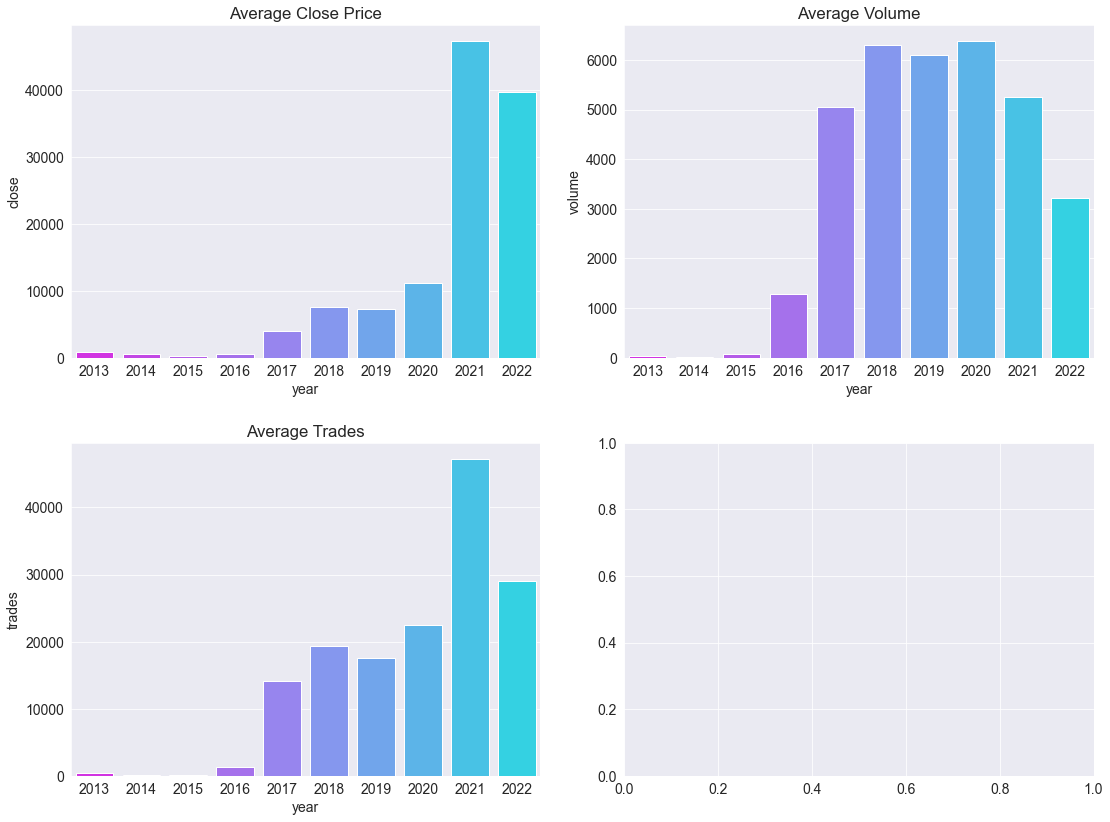

In [268]:
fig, axes = plt.subplots(2,2, figsize=(16,12))

axes[0,0].set_title("Average Close Price")
sns.barplot(ax=axes[0,0], data = btc_avg, x = btc_avg.index, y=btc_avg["close"], palette="cool_r")

axes[0,1].set_title("Average Volume")
sns.barplot(ax=axes[0,1], data = btc_avg, x = btc_avg.index, y=btc_avg["volume"],palette="cool_r")


axes[1,0].set_title("Average Trades",)
sns.barplot(ax=axes[1,0], data = btc_avg, x = btc_avg.index, y=btc_avg["trades"],palette="cool_r")


plt.tight_layout(pad=2)

In [269]:
#df_2013 = btc_df_viz[btc_df_viz["year"]==2013]
#df_2014 = btc_df_viz[btc_df_viz["year"]==2014]
#df_2015 = btc_df_viz[btc_df_viz["year"]==2015]
#df_2016 = btc_df_viz[btc_df_viz["year"]==2016]
#df_2017 = btc_df_viz[btc_df_viz["year"]==2017]
#df_2018 = btc_df_viz[btc_df_viz["year"]==2018]
#df_2019 = btc_df_viz[btc_df_viz["year"]==2019]
#df_2020 = btc_df_viz[btc_df_viz["year"]==2020]
#df_2021 = btc_df_viz[btc_df_viz["year"]==2021]
#df_2022 = btc_df_viz[btc_df_viz["year"]==2022]

#### Heatmap showing  correlation score

In [270]:
cor_df= btc_df_viz.corr()

<AxesSubplot:>

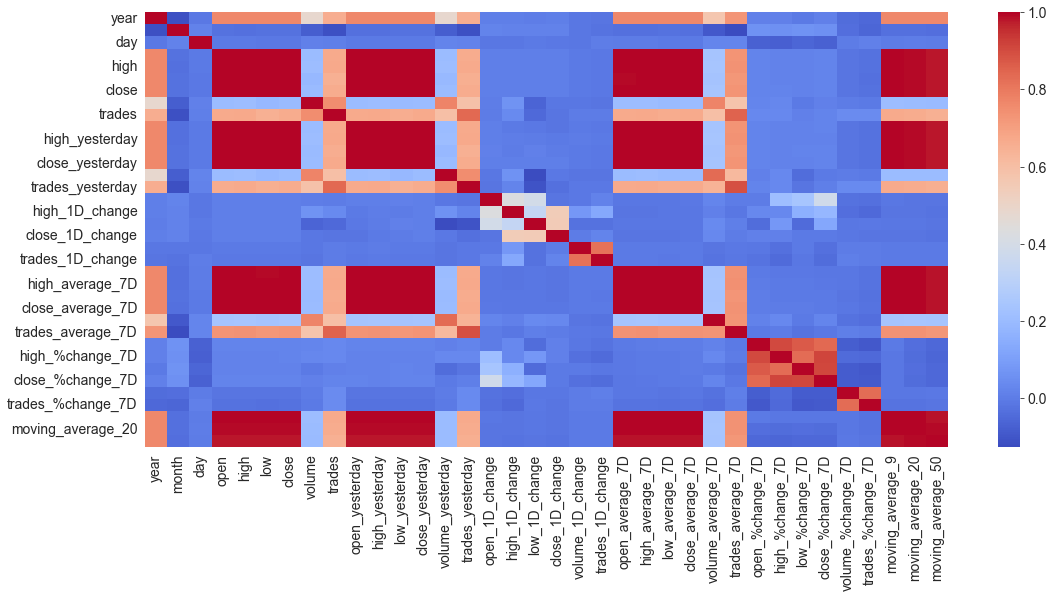

In [271]:
sns.heatmap(cor_df, cmap="coolwarm")

#### DataFrame with Dropping some Features

In [272]:
btc_df_less_features = btc_df.drop(["year", "month", "day"], axis=1) # not important

In [273]:
btc_df_less_features = btc_df_less_features.drop(["open", "high", "low","trades", "volume"], axis=1) 

# in reality, we don't know this on the current day or tomorrow day we want to predict
# we only know yesterday'open, yesterday'high, yesterday's low, and yesterday's close

In [274]:
btc_df_less_features.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


<b> Save dataframe for machine learning model </b>

In [275]:
btc_df_less_features.to_csv("data/btc_df_less_features.csv")

## MACHINE LEARNING MODEL

* Split train-test data using date since it's a time series data

* not using train-test-split from sklearn since it will mix up the data

In [276]:
btc_ml_all = pd.read_csv("data/btc_df_less_features.csv", index_col=0)

In [277]:
btc_ml_all.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [278]:
btc_ml_all.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-05-23,29070.0,29394.4,30500.0,29225.7,30268.0,1862.492124,15723.0,0.007983,0.030186,0.010316,0.029401,0.808139,0.178459,29860.900000,30574.400000,28936.342857,29716.914286,3003.501844,22435.714286,0.000583,-0.002917,0.001769,-0.002222,0.047226,-0.087159,29929.277778,31852.845,37287.416
2022-05-24,29631.8,30264.4,30630.7,28829.5,29070.0,3028.927811,22623.0,0.029597,0.004285,-0.013557,-0.039580,0.626277,0.438848,29713.742857,30479.571429,28903.414286,29608.900000,2907.180888,21537.142857,-0.002278,-0.003920,-0.001014,-0.003958,0.223454,-0.032349,29820.588889,31419.950,36940.348
2022-05-25,30084.1,29070.0,29819.7,28635.3,29631.8,2806.171996,18978.0,-0.039466,-0.026477,-0.006736,0.019326,-0.073543,-0.161119,29605.728571,30347.814286,28793.742857,29497.971429,2906.511067,20862.000000,-0.003958,-0.002873,-0.001046,-0.002899,0.120926,0.001771,29635.577778,30917.400,36600.642


#### Drop the last row because we want to predict the price of the current day

In [279]:
last_row = btc_ml_all[-1:]
last_row

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-05-25,30084.1,29070.0,29819.7,28635.3,29631.8,2806.171996,18978.0,-0.039466,-0.026477,-0.006736,0.019326,-0.073543,-0.161119,29605.728571,30347.814286,28793.742857,29497.971429,2906.511067,20862.0,-0.003958,-0.002873,-0.001046,-0.002899,0.120926,0.001771,29635.577778,30917.4,36600.642


In [280]:
btc_ml = btc_ml_all[:-1]
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [281]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-05-23,29070.0,29394.4,30500.0,29225.7,30268.0,1862.492124,15723.0,0.007983,0.030186,0.010316,0.029401,0.808139,0.178459,29860.900000,30574.400000,28936.342857,29716.914286,3003.501844,22435.714286,0.000583,-0.002917,0.001769,-0.002222,0.047226,-0.087159,29929.277778,31852.845,37287.416
2022-05-24,29631.8,30264.4,30630.7,28829.5,29070.0,3028.927811,22623.0,0.029597,0.004285,-0.013557,-0.039580,0.626277,0.438848,29713.742857,30479.571429,28903.414286,29608.900000,2907.180888,21537.142857,-0.002278,-0.003920,-0.001014,-0.003958,0.223454,-0.032349,29820.588889,31419.950,36940.348


#### Split train-test 85:15
* Can't use train-test split because it will shuffle the data/date index

In [282]:
len(btc_ml)

3091

In [283]:
train_size = (85*(len(btc_ml)))//100
train_size

2627

**Train Set**

In [284]:
train_set = btc_ml.iloc[0:train_size]
train_set.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-12,47470.4,44839.5,48703.6,44046.2,47962.8,7962.974924,75748.0,-0.035803,0.028804,0.007120,0.069464,0.234271,0.081836,41597.328571,44289.028571,40445.828571,43166.785714,8248.500798,73491.142857,0.041393,0.035176,0.032666,0.027558,0.171454,0.149587,41868.600000,37027.700,34733.454
2021-02-13,47199.9,47979.9,48925.0,46263.0,47470.4,5332.296303,61266.0,0.070036,0.004546,0.050329,-0.010266,-0.330364,-0.191187,43169.342857,45801.171429,41828.700000,44477.314286,8323.179870,76353.714286,0.027522,0.035275,0.030425,0.040106,0.201697,0.134442,42957.433333,37796.195,35208.490
2021-02-14,48649.7,47438.2,48224.1,46285.0,47199.9,2631.808897,39366.0,-0.011290,-0.014326,0.000476,-0.005698,-0.506440,-0.357458,44473.128571,46835.185714,42980.642857,45612.014286,7395.328670,71958.857143,0.040182,0.037382,0.036112,0.033548,0.201566,0.152821,44093.088889,38541.590,35658.516


**Test Set**

In [285]:
test_set = btc_ml[train_size:]
test_set.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-15,47937.1,47199.9,49700.0,47038.7,48649.7,3553.112138,50594.0,-0.005023,0.030605,0.016284,0.030716,0.350065,0.285221,45607.828571,48263.128571,44356.100000,47008.414286,7169.267541,71886.571429,0.033408,0.025476,0.029781,0.029152,0.000984,0.001608,45243.422222,39360.355,36102.686
2021-02-16,49218.7,48655.4,49043.3,45710.5,47937.1,5337.999243,61326.0,0.030837,-0.013213,-0.028236,-0.014648,0.502345,0.212120,47006.157143,48594.000000,45446.885714,47224.314286,5977.709736,65013.857143,0.029165,0.034315,0.035138,0.034931,0.113466,0.081119,46207.877778,40132.160,36536.400
2021-02-17,52130.0,47937.1,50599.9,47040.1,49218.7,6175.520692,63913.0,-0.014763,0.031739,0.029087,0.026735,0.156898,0.042184,47222.071429,48933.700000,45731.185714,47612.300000,5349.324447,60318.714286,0.034990,0.007159,0.028567,0.005090,-0.052424,-0.051662,47357.188889,41071.885,36980.184


**X_train, y_train, X_test, y_test**

<b>X_train</b>

In [286]:
X_train_new = train_set.drop(["close"], axis=1)
X_train_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [287]:
X_train = X_train_new.values
X_train.shape

(2627, 27)

<b>X_test</b>

In [288]:
X_test_new = test_set.drop(["close"], axis=1)

In [289]:
X_test_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-15,47199.9,49700.0,47038.7,48649.7,3553.112138,50594.0,-0.005023,0.030605,0.016284,0.030716,0.350065,0.285221,45607.828571,48263.128571,44356.100000,47008.414286,7169.267541,71886.571429,0.033408,0.025476,0.029781,0.029152,0.000984,0.001608,45243.422222,39360.355,36102.686
2021-02-16,48655.4,49043.3,45710.5,47937.1,5337.999243,61326.0,0.030837,-0.013213,-0.028236,-0.014648,0.502345,0.212120,47006.157143,48594.000000,45446.885714,47224.314286,5977.709736,65013.857143,0.029165,0.034315,0.035138,0.034931,0.113466,0.081119,46207.877778,40132.160,36536.400
2021-02-17,47937.1,50599.9,47040.1,49218.7,6175.520692,63913.0,-0.014763,0.031739,0.029087,0.026735,0.156898,0.042184,47222.071429,48933.700000,45731.185714,47612.300000,5349.324447,60318.714286,0.034990,0.007159,0.028567,0.005090,-0.052424,-0.051662,47357.188889,41071.885,36980.184


In [290]:
X_test = X_test_new.values
X_test.shape

(464, 27)

<b> y_train </b>

In [291]:
y_train_new = train_set["close"]

In [292]:
y_train = y_train_new.values
y_train.shape

(2627,)

<b>y_test</b>

In [293]:
y_test_new = test_set["close"]
y_test = y_test_new.values
y_test.shape

(464,)

## Support Vector Machine

In [294]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [295]:
scaler = StandardScaler()

In [296]:
X_scaled_train = scaler.fit_transform(X_train)

In [297]:
X_scaled_test = scaler.transform(X_test) 
# not using fit to avoid data leakage 

### Base Model1:  Not Scale and Not Adjust Parameters

In [298]:
svr_base1 = SVR()

In [299]:
svr_base1.fit(X_train , y_train)

SVR()

In [300]:
pred_base1 = svr_base1.predict(X_test)

In [301]:
print(np.sqrt(mean_squared_error(y_test, pred_base1)))

44399.105273904104


In [302]:
print(r2_score(y_test, pred_base1))

-22.28280133848314


### Base Model2: Scale but Not Adjust Parameters

In [303]:
svr_base2 = SVR()

In [304]:
svr_base2.fit(X_scaled_train, y_train)

SVR()

In [305]:
pred_base2 = svr_base2.predict(X_scaled_test)

In [306]:
print(np.sqrt(mean_squared_error(y_test, pred_base2)))

44278.07223936159


In [307]:
print(r2_score(y_test, pred_base2))

-22.156035398969788


### Model 3: Adjusted Model: Scale + Adjust Parameters

In [308]:
param_grid = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [309]:
svr = SVR()

In [310]:
%%time
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2')

CPU times: user 83 µs, sys: 168 µs, total: 251 µs
Wall time: 267 µs


In [311]:
%%time
grid_search.fit(X_scaled_train, y_train)

CPU times: user 1min 18s, sys: 386 ms, total: 1min 18s
Wall time: 1min 19s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [312]:
%%time
print(grid_search.best_params_)

{'C': 300, 'epsilon': 1e-05, 'kernel': 'linear'}
CPU times: user 110 µs, sys: 84 µs, total: 194 µs
Wall time: 172 µs


In [313]:
svr_best = grid_search.best_estimator_

In [314]:
pred_svr_adjusted = svr_best.predict(X_scaled_test)

In [315]:
print(np.sqrt(mean_squared_error(y_test, pred_svr_adjusted)))

1796.2868858084337


In [316]:
print(r2_score(y_test, pred_svr_adjusted))

0.9618900662034715


In [317]:
len(y_test)

464

In [318]:
len(pred_svr_adjusted)

464

In [319]:
test_set["close"]

date
2021-02-15    47937.1
2021-02-16    49218.7
2021-02-17    52130.0
2021-02-18    51600.9
2021-02-19    55926.9
               ...   
2022-05-20    29167.5
2022-05-21    29403.5
2022-05-22    30268.0
2022-05-23    29070.0
2022-05-24    29631.8
Name: close, Length: 464, dtype: float64

In [320]:
df_compare = pd.DataFrame(columns=["actual_price", "predicted_price"])

In [321]:
df_compare

,actual_price,predicted_price


In [322]:
df_compare["actual_price"] = test_set["close"]

In [323]:
df_compare["predicted_price"] = pred_svr_adjusted

In [324]:
df_compare["difference"] =  df_compare["actual_price"] - df_compare["predicted_price"] 

In [325]:
df_compare.head(10)

,actual_price,predicted_price,difference
date,,,
2021-02-15,47937.1,48949.006889,-1011.906889
2021-02-16,49218.7,48044.326175,1174.373825
2021-02-17,52130.0,49387.062768,2742.937232
2021-02-18,51600.9,51890.016603,-289.116603
2021-02-19,55926.9,51963.344876,3963.555124
2021-02-20,55938.7,55086.378787,852.321213
2021-02-21,57478.3,56134.602959,1343.697041
2021-02-22,54154.8,57512.860416,-3358.060416
2021-02-23,48899.8,53073.550536,-4173.750536


In [326]:
df_compare.tail(15)

,actual_price,predicted_price,difference
date,,,
2022-05-10,30999.9,30995.470137,4.429863
2022-05-11,28994.1,31083.016310,-2088.916310
2022-05-12,28943.4,29362.398429,-418.998429
2022-05-13,29222.6,28276.641902,945.958098
2022-05-14,30048.2,29391.654952,656.545048
2022-05-15,31296.9,29606.128965,1690.771035
2022-05-16,29826.1,30700.062780,-873.962780
2022-05-17,30408.3,29803.875127,604.424873
2022-05-18,28664.3,30074.355908,-1410.055908


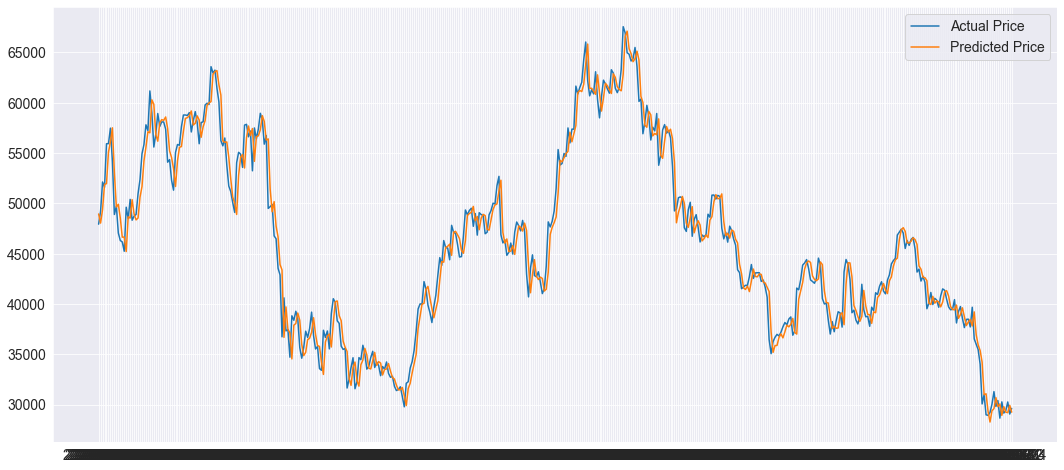

In [327]:
plt.plot(df_compare.index , df_compare.actual_price, label="Actual Price")
plt.plot(df_compare.index , df_compare.predicted_price, label="Predicted Price")
plt.legend()
plt.show()


# LIVE PREDICTION

* This section is trying to test the model performance on live prediction
* The model will predict the price the next day
* Therefore, there will be only one row of test set 
* y_test will be known at the end of trading day

#### 1. Dataset is from 2013 to Current day

In [328]:
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [329]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-05-23,29070.0,29394.4,30500.0,29225.7,30268.0,1862.492124,15723.0,0.007983,0.030186,0.010316,0.029401,0.808139,0.178459,29860.900000,30574.400000,28936.342857,29716.914286,3003.501844,22435.714286,0.000583,-0.002917,0.001769,-0.002222,0.047226,-0.087159,29929.277778,31852.845,37287.416
2022-05-24,29631.8,30264.4,30630.7,28829.5,29070.0,3028.927811,22623.0,0.029597,0.004285,-0.013557,-0.039580,0.626277,0.438848,29713.742857,30479.571429,28903.414286,29608.900000,2907.180888,21537.142857,-0.002278,-0.003920,-0.001014,-0.003958,0.223454,-0.032349,29820.588889,31419.950,36940.348


#### 2. Training Set is from 2013 to yesterday price

<b> X_train</b>

In [330]:
X_train_new2 = btc_ml.drop(["close"], axis=1)
X_train_new2.head(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [331]:
X_train_new2.tail(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-05-23,29394.4,30500.0,29225.7,30268.0,1862.492124,15723.0,0.007983,0.030186,0.010316,0.029401,0.808139,0.178459,29860.900000,30574.400000,28936.342857,29716.914286,3003.501844,22435.714286,0.000583,-0.002917,0.001769,-0.002222,0.047226,-0.087159,29929.277778,31852.845,37287.416
2022-05-24,30264.4,30630.7,28829.5,29070.0,3028.927811,22623.0,0.029597,0.004285,-0.013557,-0.039580,0.626277,0.438848,29713.742857,30479.571429,28903.414286,29608.900000,2907.180888,21537.142857,-0.002278,-0.003920,-0.001014,-0.003958,0.223454,-0.032349,29820.588889,31419.950,36940.348


In [332]:
X_train2 = X_train_new2.values
X_train2.shape

(3091, 27)

<b> y_train </b>

In [333]:
y_train_new = btc_ml["close"]
y_train2 = y_train_new.values
y_train2.shape

(3091,)

#### 3. Test set is current trading day , today ( the last row)

In [334]:
X_test2 = last_row.drop(["close"], axis=1)
X_test2

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-05-25,29070.0,29819.7,28635.3,29631.8,2806.171996,18978.0,-0.039466,-0.026477,-0.006736,0.019326,-0.073543,-0.161119,29605.728571,30347.814286,28793.742857,29497.971429,2906.511067,20862.0,-0.003958,-0.002873,-0.001046,-0.002899,0.120926,0.001771,29635.577778,30917.4,36600.642


<b> y_actual </b>

#### 4. Model Prediciton

In [335]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [336]:
scaler = StandardScaler()

In [337]:
X_scaled_train2 = scaler.fit_transform(X_train2)

In [338]:
X_scaled_test2 = scaler.transform(X_test2) # not using fit to avoid data leakage 

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [339]:
param_grid2 = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [340]:
svr2 = SVR()

In [341]:
%%time
grid_search2 = GridSearchCV(svr2, param_grid2, cv=5, scoring='r2')

CPU times: user 76 µs, sys: 2 µs, total: 78 µs
Wall time: 87.7 µs


In [342]:
%%time
grid_search2.fit(X_scaled_train2, y_train2)

CPU times: user 1min 12s, sys: 357 ms, total: 1min 13s
Wall time: 1min 13s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [343]:
%%time
print(grid_search2.best_params_)

{'C': 500, 'epsilon': 0.001, 'kernel': 'linear'}
CPU times: user 175 µs, sys: 119 µs, total: 294 µs
Wall time: 263 µs


In [344]:
svr_best2 = grid_search2.best_estimator_

In [345]:
pred_svr_adjusted2 = svr_best2.predict(X_scaled_test2)

In [346]:
pred_svr_adjusted2

array([29424.99397965])

#### Create a new dataframe 

In [347]:
new_cols = ["date","predict", "actual"]

In [348]:
df_actual = pd.DataFrame(columns=new_cols)
df_actual

,date,predict,actual


In [349]:
df_actual["date"]= last_row.index
df_actual

,date,predict,actual
0,2022-05-25,NaN,NaN


In [350]:
df_actual["predict"] = pred_svr_adjusted2
df_actual

,date,predict,actual
0,2022-05-25,29424.99398,NaN


In [351]:
df_actual[0:1]["date"].values

array(['2022-05-25'], dtype=object)

In [352]:
x = np.asscalar(df_actual[0:1]["date"].values)
x

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_8179/3410238289.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  x = np.asscalar(df_actual[0:1]["date"].values)


'2022-05-25'

#### Call Kraken OHLCVVT API again at the end of day 
#### Run at the end of day

resp2 = requests.get('https://api.kraken.com/0/public/OHLC?pair=XBTUSD&interval=1440&since=unix_now').json()

xbt_new_df = pd.DataFrame(resp2["result"]['XXBTZUSD'])
xbt_new_df.columns = kraken_ohlc_cols
xbt_new_df["date"] = pd.to_datetime(xbt_new_df["date"],unit='s')
xbt_new_df.tail(10)

filter = xbt_new_df["date"]==x
filter

xbt_new_df[filter]

xbt_new_df[filter]["close"]

df_actual["actual"] = xbt_new_df[filter]["close"].values

df_actual

df_compare2 = pd.DataFrame(columns=new_cols )

df_compare2

df_compare2.append(df_actual)

print(np.sqrt(mean_squared_error(y_test2, pred_svr_adjusted2)))

print(r2_score(y_test2, pred_svr_adjusted2))

plt.plot(pred_svr_adjusted, label="SVR Predition Price")
plt.plot(y_test, label="Actual Close Price")
plt.legend()